# Applying Image Blurring Techniques to Create Artistic Background Effects in Portrait Photography

## Importing Libraries

In [1]:
import cv2
import numpy as np
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt

## Preparing the Data Set

In [2]:
def blur_background_with_deeplab(image_path, blur_kernel=(51, 51)):
    # Load DeepLabv3 model
    model = models.segmentation.deeplabv3_resnet101(weights="DEFAULT").eval()

    # Load the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}.")
        return None, None

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transform image for DeepLabv3
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((520, 520)),  # Resize to the model's input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image_rgb).unsqueeze(0)

    # Perform segmentation
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    segmentation = output.argmax(0).byte().cpu().numpy()

    # Resize segmentation map to match the original image size
    segmentation = cv2.resize(segmentation, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create masks
    mask_subject = np.where(segmentation == 15, 1, 0).astype('uint8')  # Class 15 corresponds to 'person'
    mask_subject = mask_subject * 255  # Scale to 0-255 for OpenCV operations
    mask_background = cv2.bitwise_not(mask_subject)

    # Blur the background
    blurred_image = cv2.GaussianBlur(image, blur_kernel, 0)

    # Combine subject and blurred background
    subject = cv2.bitwise_and(image, image, mask=mask_subject)
    background = cv2.bitwise_and(blurred_image, blurred_image, mask=mask_background)
    result = cv2.add(subject, background)

    # Convert original image and result to RGB for display
    original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    return original_rgb, result_rgb

## Processing the Results

In [3]:
def plot_separate_images(image_paths, plot_all=False, single_image=None):
    if plot_all:
        # Process and plot each image separately
        for image_path in image_paths:
            original_rgb, result_rgb = blur_background_with_deeplab(image_path)
            if original_rgb is not None and result_rgb is not None:
                # Create a new figure for each image
                plt.figure(figsize=(10, 5))

                # Original image
                plt.subplot(1, 2, 1)
                plt.imshow(original_rgb)
                plt.title(f"Original {image_path}")
                plt.axis('off')

                # Blurred image
                plt.subplot(1, 2, 2)
                plt.imshow(result_rgb)
                plt.title(f"Artistic Background {image_path}")
                plt.axis('off')

                plt.show()
    elif single_image:
        # Process and plot only the selected single image
        if single_image in image_paths:
            original_rgb, result_rgb = blur_background_with_deeplab(single_image)
            if original_rgb is not None and result_rgb is not None:
                # Create a new figure for the single image
                plt.figure(figsize=(10, 5))

                # Original image
                plt.subplot(1, 2, 1)
                plt.imshow(original_rgb)
                plt.title(f"Original {single_image}")
                plt.axis('off')

                # Blurred image
                plt.subplot(1, 2, 2)
                plt.imshow(result_rgb)
                plt.title(f"Artistic Background {single_image}")
                plt.axis('off')

                plt.show()
        else:
            print(f"Image '{single_image}' not found in the folder.")
    else:
        print("No valid option selected. Please choose 'all' or a valid single image.")

## Swowing the Result

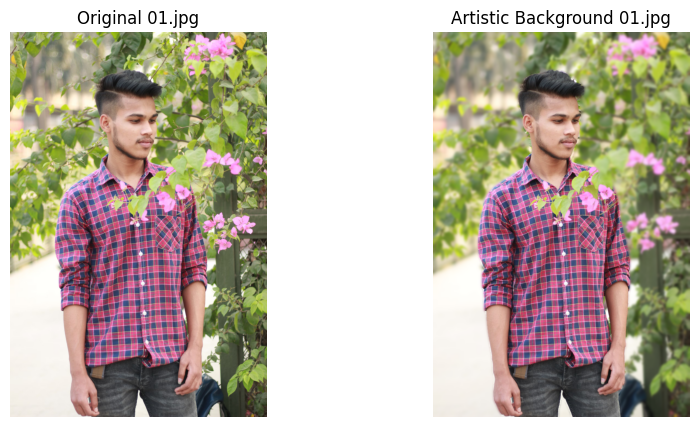

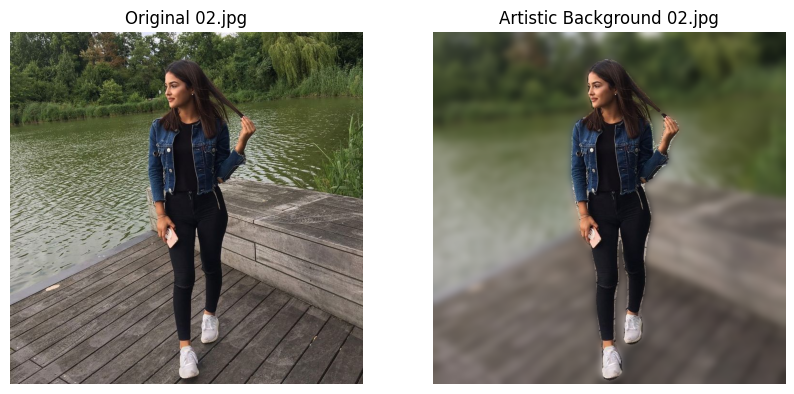

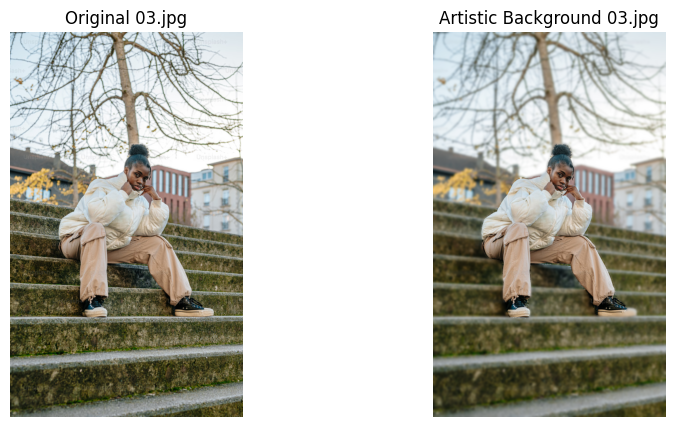

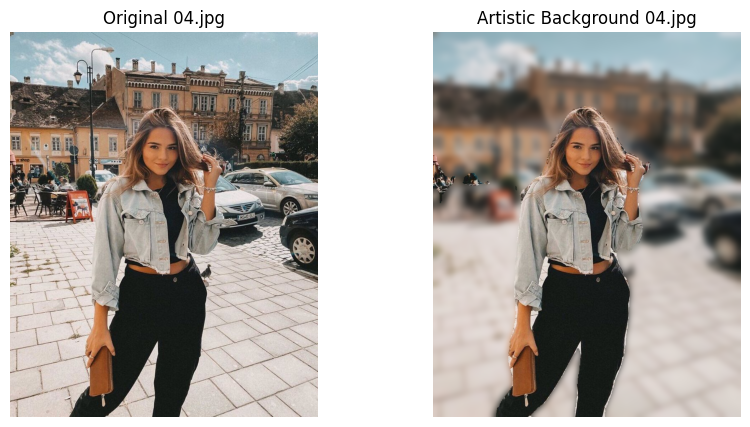

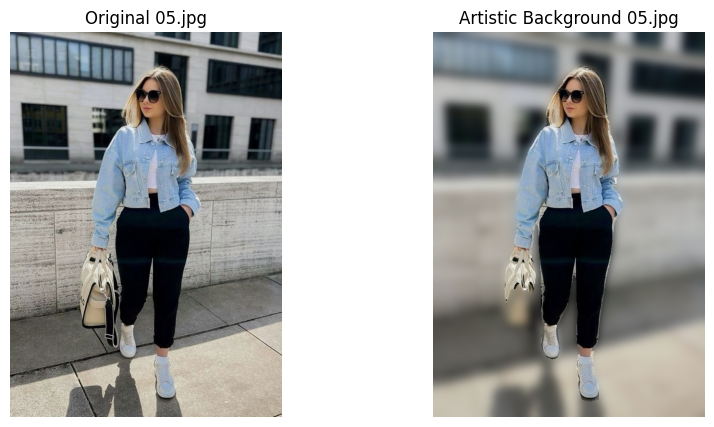

In [6]:
# Example usage
image_paths = ['01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg']  # List of image paths

# Ask user if they want to process all images or just one
user_choice = 'all'

if user_choice == "all":
    plot_separate_images(image_paths, plot_all=True)
elif user_choice in image_paths:
    plot_separate_images(image_paths, single_image=user_choice)
else:
    print("Invalid input. Please enter 'all' or a valid image filename.")